# Bike Sharing Demand Prediction

### Όνομα Ομάδας 
**e-Class:** Ομάδα 15  
**Kaggle:** PitaGyroFotopoulo

### Μέλη Ομάδας
**Ντυμένος Παναγιώτης** 3160120  
**Φωτόπουλος Γεώργιος** 3130220

## Περιγραφή Notebook

Στο συγκεκριμένο Notebook, έχουμε τον κώδικα που χρησιμοποιήσαμε για την πρόβλεψη του αριθμού των ποδηλάτων που ενοικιάστηκαν,
καθώς και κάποιες από τις μεθόδους που χρησιμοποιήσαμε πριν καταλήξουμε στο τελικό αποτέλεσμα.\
Ο κώδικας τρέχει σε python 3.6 64bit.

### Συνοπτικά:
**Feature Engineering:** Παρατηρήσαμε ότι τα περισσότερα δεδομένα στο DataFrame μας, κυμαίνονται κυρίως στις τιμές 0-200. Έτσι, λογαριθμίσαμε(***log1p()***) τον αριθμό των ποδηλάτων, με αποτέλεσμα την κανονικοποίηση των δεδομένων και την καλύτερη διανομή τους. Μετά το train που γίνεται βάση των νέων τιμών, γίνεται invert των προβλέψεων, με την χρήση της μεθόδου ***expm1()***. Επιπλέον, έγινε κανονικοποίηση της στήλης *temp* με την μέθοδο ***sqrt()*** και της στήλης *humidity* με την χρήση της μεθόδου ***square()***. Τέλος, προσθέσαμε και την στήλη *month_year*, η οποία αποτελείται από την πρόσθεση των στηλών *month*, *year* και μας δίνει ένα ακόμα αναγνωριστικό της εκάστοτε περίπτωσης/γραμμής.

**Αλγόριθμοι Μάθησης:** Kαταλήξαμε στους αλγορίθμους RandomForestRegressor και CatBoostRegressor, οι οποίοι μετά από χρήση του RandomizedSearchCV, έχουν τις καλύτερες παραμέτρους για τα δεδομένα μας. Έπειτα από αρκετές δοκιμές, καταλήξαμε στο ότι ο καλύτερος τρόπος να κάνουμε ensemble αυτούς τους δυο αλγορίθμους, ήταν να κρατήσουμε το 90% των προβλέψεων του Booster και το 10% των δέντρων.

**Τελική Πρόβλεψη:** Στο τελικό submit, οι προβλέψεις έχουν μετατραπεί απο float σε int, με αποτέλεσμα την μεγαλύτερη ακρίβεια πρόβλεψης αλλά και την αληθοφανή αναπαράστασή τους. 

## Κώδικας

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
# Reading Training and Test data 
df_train = pd.read_csv('dataset/train.csv')

df_test = pd.read_csv('dataset/test.csv')

# Rename columns
df_test.rename(columns={'weathersit': 'weather',
                        'mnth': 'month',
                        'hr': 'hour',
                        'yr': 'year',
                        'hum': 'humidity',
                        'cnt': 'count'}, inplace=True)

df_train.rename(columns={'weathersit': 'weather',
                         'mnth': 'month',
                         'hr': 'hour',
                         'yr': 'year',
                         'hum': 'humidity',
                         'cnt': 'count'}, inplace=True)

# Dropping unnecessary columns
# 'temp' and 'atemp' are strongly correlated. To reduce the dimensionality of the predictive model, the feature atemp is dismissed.
# 'windspeed' has little correlation with count.
df_train = df_train.drop(['atemp', 'windspeed', 'casual', 'registered'], axis=1)

df_test = df_test.drop(['atemp', 'windspeed'], axis=1)

Σε αυτό το σημείο, ελέγχουμε το distribution της στήλης *count* και βλέπουμε πως είναι πυκνή στις χαμηλές τιμές. 

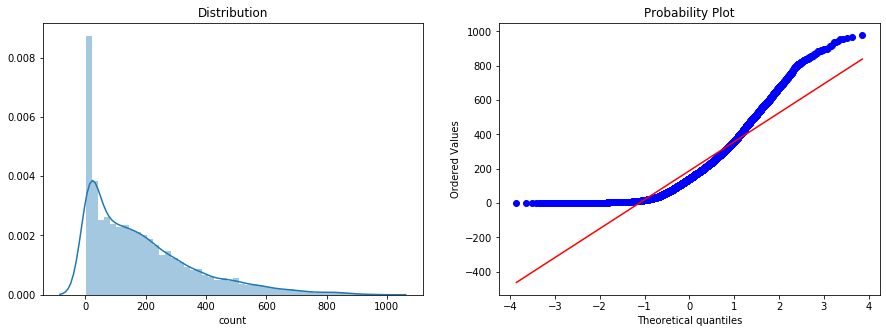

In [3]:
# Distribution
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(15, 5)

# count without transformation
ax = sn.distplot(df_train["count"] ,ax=axes[0])
stats.probplot(df_train["count"], dist='norm', fit=True, plot = axes[1])
ax.set(title = "Distribution")
plt.show()

Χρησιμοποιώντας την μέθοδο log1p() του πακέτου numpy, το distribution στις τιμές του *count* μετατρέπεται ως εξής:

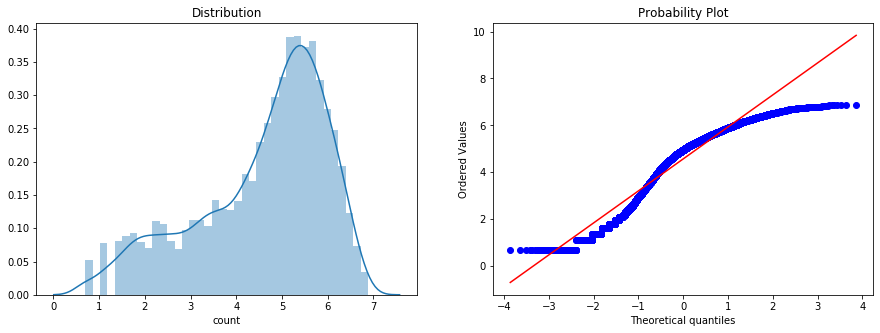

In [4]:
# Distribution
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(15, 5)

# count with transformation
ax = sn.distplot(np.log1p(df_train["count"]), ax=axes[0])
stats.probplot(np.log1p(df_train["count"]), dist='norm', fit=True, plot=axes[1])
ax.set(title = "Distribution")
plt.show()

Ακόμα και τώρα, τα δεδομένα μας δεν έχουν τέλειο distribution αλλά είναι σίγουρα καλύτερα από πριν. Αυτή η μετατροπή βελτιώνει σημαντικά την ακρίβεια του μοντέλου ,όπως θα φανεί και παρακάτω.

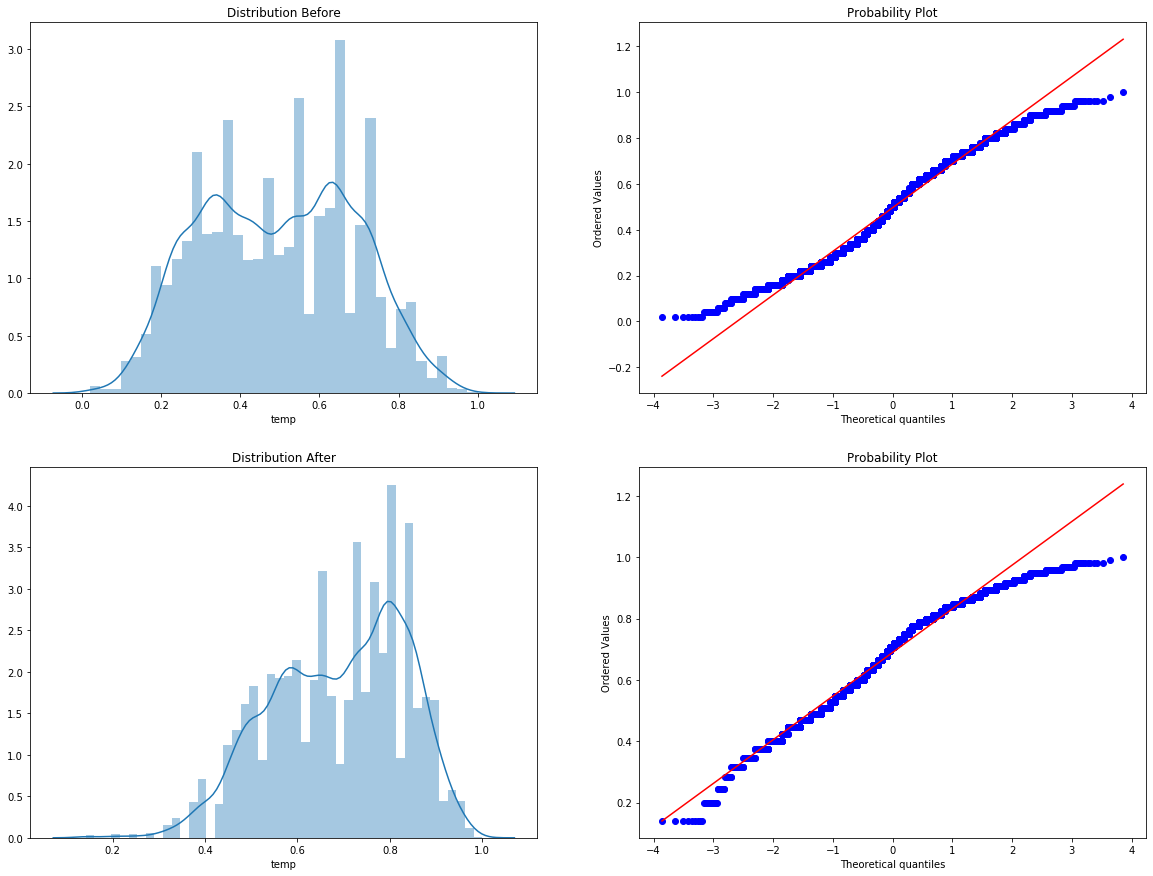

In [5]:
# Distribution temp
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(20, 15)
ax1 = sn.distplot(df_train["temp"], ax=axes[0][0])
ax1.set(title="Distribution Before")
stats.probplot(df_train["temp"], dist='norm', fit=True, plot=axes[0][1])
ax2 = sn.distplot(np.sqrt(df_train["temp"]), ax=axes[1][0])
stats.probplot(np.sqrt(df_train["temp"]), dist='norm', fit=True, plot=axes[1][1])
ax2.set(title="Distribution After")
plt.show()

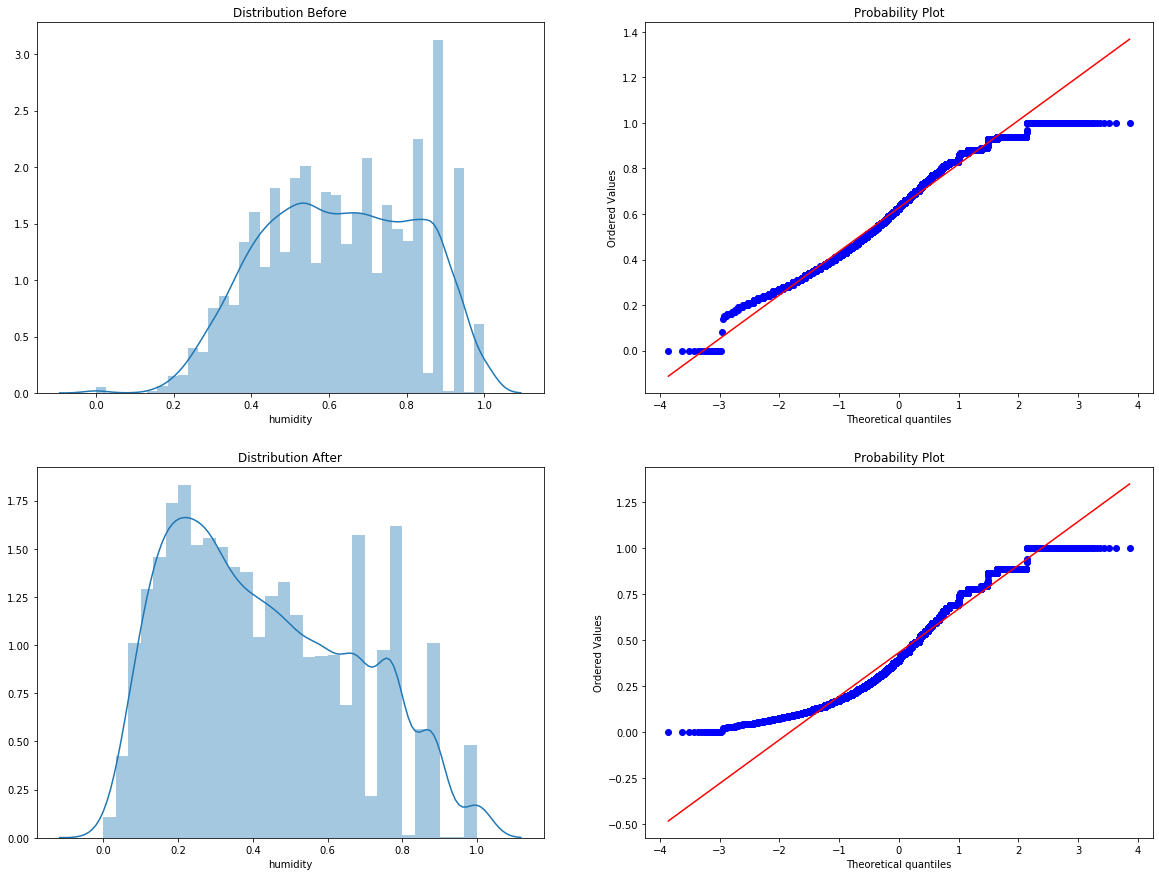

In [6]:
# Distribution humidity
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(20, 15)
ax3 = sn.distplot(df_train["humidity"], ax=axes[0][0])
ax3.set(title="Distribution Before")
stats.probplot(df_train["humidity"], dist='norm', fit=True, plot=axes[0][1])
ax4 = sn.distplot(np.square(df_train["humidity"]), ax=axes[1][0])
stats.probplot(np.square(df_train["humidity"]), dist='norm', fit=True, plot=axes[1][1])
ax4.set(title="Distribution After")
plt.show()

In [7]:
# Add column for better identification, to help regressors
df_train['month_year'] = df_train['month'] + df_train['year']

# Normalize column temp using square root
df_train['temp'] = np.sqrt(df_train['temp'])

# Normalize column humidity using square
df_train['humidity'] = np.square(df_train['humidity'])

# Split dataframe to features and labels

# Labels
y = df_train['count']

# Features
X = df_train[['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather', 'temp', 'humidity',
              'month_year']]

Ακολουθεί ένα μενού στο οποίο έχουμε τρεις επιλογές. Η πρώτη κάνει train και τοπικό test χρησιμοποιώντας την μέθοδο *train_test_split* χωρίζοντας το αρχείο *train.csv* σε 70% train και 30% test, έτσι ώστε να μπορούμε να κάνουμε evaluate το μοντέλο μας χωρίς να χρησιμοποιούμε το kaggle.

In [8]:
# Show Menu
train_or_submit = input("1. Train and Test the Model. \n2. Train and Submit. \n3. Perform RandomizedSearchCV. \n> ")

1. Train and Test the Model. 
2. Train and Submit. 
3. Perform RandomizedSearchCV. 
> 1


In [9]:
# Train and Test Locally
if train_or_submit == '1':
    print('Splitting Data -> 70% for Training and 30% for Testing.\n')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Perform log1p() transformation on labels
    y_train = np.log1p(y_train)

    # CatBoost
    print('Training with CatBoost... ')
    booster = CatBoostRegressor(learning_rate=0.02, iterations=2700, depth=9, silent=True)

    # Train
    booster.fit(X_train, y_train)
    booster_pred = booster.predict(X_test)
    booster_pred[booster_pred < 0] = 0

    # Reverse transformation
    booster_pred = np.expm1(booster_pred)

    print('Done! ')
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, booster_pred.astype(int))))
    print('R2:', r2_score(y_test, booster_pred.astype(int)))

    # Random Forest
    print('\nTraining with Random Forest... ')
    rf = RandomForestRegressor(n_estimators=1600, min_samples_split=2,
                               min_samples_leaf=1, max_depth=50, random_state=42)

    # Train
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_pred[rf_pred < 0] = 0

    # Reverse transformation
    rf_pred = np.expm1(rf_pred)

    print('Done!')
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, rf_pred.astype(int))))
    print('R2:', r2_score(y_test, rf_pred.astype(int)))

    # Ensemble
    y_pred = booster_pred * 0.9 + rf_pred * 0.1

    print('\nEnsemble:')
    print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred.astype(int))))
    print('R2:', r2_score(y_test, y_pred.astype(int)))

Splitting Data -> 70% for Training and 30% for Testing.

Training with CatBoost... 
Done! 
RMSLE: 0.2774618061099604
R2: 0.955232824726416

Training with Random Forest... 
Done!
RMSLE: 0.323776639329407
R2: 0.9381978839178201

Ensemble:
RMSLE: 0.2780401434889627
R2: 0.955148817480487


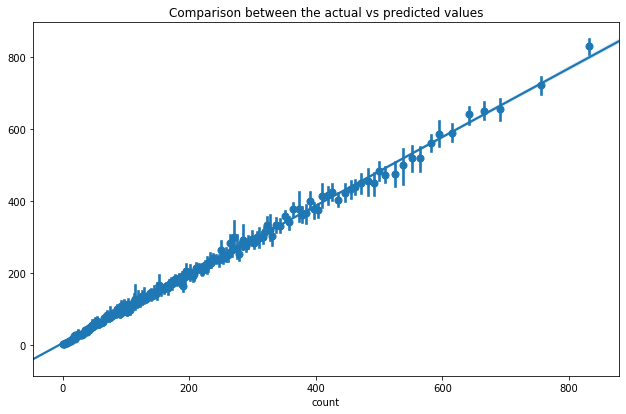

In [10]:
if train_or_submit == '1':
    fig, axes = plt.subplots()
    fig.set_size_inches(10.5, 6.5)
    ax = sn.regplot(y_test, y_pred.astype(int), x_bins = 200, ax = axes)
    ax.set(title = "Comparison between the actual vs predicted values")
    plt.show()

Η δεύτερη κάνει train με όλο το αρχείο *train.csv* και χρησιμοποιήθηκε στο τελικό submit του kaggle.

In [11]:
# Train and Submit
if train_or_submit == '2':
    # Perform same transformations as train set
    df_test['month_year'] = df_test['month'] + df_test['year']
    df_test['temp'] = np.sqrt(df_test['temp'])
    df_test['humidity'] = np.square(df_test['humidity'])

    # Perform log1p() transformation on labels
    y = np.log1p(y)

    print('Training in progress...\n')
    # CatBoost
    print('Waiting for CatBoost... ')
    booster = CatBoostRegressor(learning_rate=0.02, iterations=2700, depth=9, silent=True)

    # Train
    booster.fit(X, y)
    booster_pred = booster.predict(df_test)
    booster_pred[booster_pred < 0] = 0

    # Reverse Transformation
    booster_pred = np.expm1(booster_pred)
    print('Done!\n')

    # Random Forest
    print('Waiting for Random Forest... ')
    rf = RandomForestRegressor(n_estimators=1600, min_samples_split=2,
                               min_samples_leaf=1, max_depth=50, random_state=42)

    # Train
    rf.fit(X, y)
    rf_pred = rf.predict(df_test)
    rf_pred[rf_pred < 0] = 0

    # Reverse Transformation
    rf_pred = np.expm1(rf_pred)

    # Ensemble
    y_pred = booster_pred * 0.9 + rf_pred * 0.1

    print('Done!\n')

    # Make the submission file
    submission = pd.DataFrame()
    submission['Id'] = range(y_pred.shape[0])

    # Cast predictions to int
    submission['Predicted'] = y_pred.astype(int)
    submission.to_csv("submission.csv", index=False)
    print('Made the submission file..')

Η τρίτη υλοποιεί το *RandomSearchCV* που χρησιμοποιήθηκε και υπάρχει για λόγους εξέτασης της εργασίας μας. 

In [12]:
# RandomizedSearchCV
if train_or_submit == '3':
    boost_or_rf = input("1. CatBoost. \n2. RandomForest. \n> ")
    
    if boost_or_rf == '1':
        y = np.log1p(y)

        iterations = [int(x) for x in np.linspace(start=100, stop=4000, num=10)]
        learning_rate = [0.02, 0.05, 0.1, 0.3]
        depth = [4, 5, 6, 7, 8, 9, 10, 11, 12]
        random_grid = {'iterations': iterations,
                       'learning_rate': learning_rate,
                       'depth': depth
                       }

        boost = CatBoostRegressor(silent=True)

        boost_random = RandomizedSearchCV(estimator=boost, param_distributions=random_grid, n_iter=100, cv=3,
                                          verbose=2, random_state=42, n_jobs=-1)

        boost_random.fit(X, y)

        print(boost_random.best_params_)

        # Best Params for Count = {'learning_rate': 0.02, 'iterations': 2700, 'depth': 9}

        chose_correct = True

    elif boost_or_rf == '2':
        y = np.log1p(y)

        n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
        max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [1, 2, 4]
        bootstrap = [True, False]
        random_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}

        rf = RandomForestRegressor()

        rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3,
                                       verbose=2,
                                       random_state=42, n_jobs=-1)

        rf_random.fit(X, y)

        print(rf_random.best_params_)

        # Best Params for Count = n_estimators =1600, min_samples_split = 2, min_samples_leaf = 1, max_depth = 50,
        #                                    bootstrap = True


# Επιπλέον Δοκιμές

### Feature Engineering
- **One-Hot Encoding:** Χρησιμοιήσαμε one-hot σε Linear Regression και όπως ήταν φυσικό, βελτιώθηκε το μοντέλο μας. Όταν όμως ασχοληθήκαμε με δέντρα και ιδιαίτερα με τον CatBoost, η ακρίβεια των προβλέψεων μειώθηκε δραματικά. Η χρήση του έγινε με την μέθοδο get_dummies(), ενώ δοκιμάσαμε να κωδικοποιήσουμε όλο το dataframe, μερικές στήλες αλλά και μεμονωμένες. Αργότερα μάθαμε πως ο CatBoost χειρίζεται άψογα τις κατηγορικές μεταβλητές και σε όσα διαβάσαμε για αυτόν, πάντα τονιζόταν πως το one-hot ήταν αχρηστό. Ομοίως και για τον Random Forest.  
<br/>
- **Outliers:** Όσον αφορά τους outliers στο dataframe μας, είδαμε πως δεν έχουμε πουθενά λανθασμένες, υπερβολικά λάθος ή NaN τιμές, επομένως δεν έχουν και μεγάλη επίδραση στα αποτελέσματα του μοντέλου μας. Ωστόσο, για την εύρεσή τους χρησιμοποιήσαμε τους αλγορίθμους ***zscore***, ***IQR*** και είχαμε σαν αποτέλεσμα περίπου 200-300 πιθανούς outliers. Ότι δοκιμάσαμε, είχε πολύ μικρό impact στο μοντέλο και θεωρήσαμε ότι θα χαλάσουμε το regularization. Επομένως δεν έμεινε καμία προσπάθειά μας στον τελικό κώδικα.  
<br/>
- **Transformation/Normalization:** Έγιναν διάφορες δοκιμές στις στήλες *temp* και *humidity* με αλγορίθμους όπως ***RobustScaler***, ***MinMaxScaler*** και ***StandardScaler*** πριν καταλήξουμε στις *sqrt* και *square*.  
<br/>
- **Drop Columns:** Ενώ δοκιμάσαμε να κάνουμε train με μερικές από τις στήλες του dataframe, καταλήξαμε στο να τα χρησιμοποιήσουμε όλα και μάλιστα να προσθέσουμε και μια στήλη επιπλέον.

### Μοντέλα Regressor/Αλγορίθμων
- **L1/L2 Regularization:** Υλοποιήσαμε τα μοντέλα L1/L2 και αν και καταλήξαμε σε μεγαλύτερη ακρίβεια συγκριτικά με τον Linear Regression και σε ελάχισατο train time, απευθυνθήκαμε σε άλλα μοντέλα καθώς το RMSLE κυμαινόταν σε επίπεδο άνω του 1.    
<br/>
- **Boosters:** AdaBoost, GradientBoost, XGBoost, lightGBM. Όσον αφορά τους boosters, καταλήξαμε σε CatBoost γιατί υπερτερεί σε χρόνο και ακρίβεια. Αμέσως επόμενος ήταν ο XGBoost, ο οποίος υστερούσε σε χρόνο εκπαίδευσης και ο GradientBoost που υστερούσε σε ακρίβεια. Οι υπόλοιποι, υστερούσαν και στα δυο κατά πολύ με διαφορά RMSLE 0.2 από τους 3 πρώτους.
<br/>
- **Trees:** DecisionTreeRegressor, ExtraTreesRegressor. Καταλήξαμε σε RandomForest, παρόλο που είναι ο αλγόριθμος με τον μεγαλύτερο χρόνο εκπαίδευσης γιατί μας έλυσε τα χέρια στο θέμα του overfitting και είχε την μεγαλύτερη ακρίβεια.  
<br/>
- **Ensemble Models:** VotingRegressor, StackingRegressor.

### Casual/Registered
Για μεγάλο χρονικό διάστημα το μοντέλο μας έκανε διαφορετικό train σε casual και διαφορετικό σε registered. Σε συνδυασμό με το ensemble model (*XGBoost, RandomForest*) καταφέραμε να πέσουμε από 0.32 σε 0.30 στο kaggle. Κάναμε διαφορετικό fit σε casual, registered και τα προσθέταμε, έτσι ώστε να έχουμε ένα predict του count. Ωστόσο με την κανονικοποιήση του count, τα αποτελέσματα του μοντέλου casual/registered ήταν χαμηλότερα. Ακόμα και όταν κάναμε κανονικοποίηση σε casual και registered ξεχωριστά, το μοντέλο είχε χαμηλότερη ακρίβεια από αυτήν του count.

### PCA
Προσπαθήσαμε να μειώσουμε τις διαστάσεις των δεδομένων μας, με την χρήση του αλγορίθμου PCA χωρίς όμως κάποιο αποτέλεσμα και καταλήξαμε ότι ο όγκος των δεδομένων/dataframe μας, δεν χρειαζόταν dimensionality reduction.

### Neural Network
Για αρκετό καιρό τα δέντρα μας είχαν φανεί κατώτερα, από την στιγμή που ήμαστε σε χαμηλή θέση στο kaggle αλλά με σκορ 0.32, το οποίο δεν θεωρείται κακό. Κάναμε μια προσπάθεια με νευρωνικά δίκτυα και one-hot, η οποία τελικά δεν μας ικανοποίησε και αποφασίσαμε να αφιερώσουμε χρόνο στην βελτίωση του προηγούμενου μοντέλου. Έχουμε, ενδεικτικά τον κώδικα που χρησιμοποιήσαμε χωρίς όμως να είναι runnable/compilable έτσι ώστε να μην γεμίσουμε το notebook με κώδικες εκτός εργασίας. 


In [ ]:
# Part of NN code
np.random.seed(0)
model = Sequential()
model.add(Flatten(input_shape=(1, 57)))
model.add(Dense(32, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="relu"))

model.compile(optimizer='adam', loss="mean_squared_logarithmic_error", metrics=['mean_squared_logarithmic_error'])

X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

model.fit(X_train, Y_train, epochs=60, shuffle=False)